# 伝送シミュレーションライブラリpyoptの使用方法

In [25]:
# ライブラリのインポート
import sys
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from PIL import Image

# pyoptのインポート
sys.path.append('../')
from pyopt.util import fft, ifft, save_pickle, load_pickle, sampling_signal
from pyopt import modulate as md
from pyopt import transmission as tr

# 1. 様々な2値符号の生成

## 1.1. PRBSの生成

In [33]:
N = 13  # PRBSの次数(5~17次)
itr = 1  # PRBSの繰り返し回数

bitsq_prbs = md.prbs(N=N, itr=itr)

In [35]:
print('ビット列: ', bitsq_prbs[:128])
print('ビット長: ', bitsq_prbs.shape)

ビット列:  [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0
 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1]
ビット長:  (8192,)


## 1.2. Random符号の生成

In [6]:
seed = 1234  # 乱数シード
bit_num = 128  # ビット長を指定

np.random.seed(seed=seed)
bitsq_random = np.random.randint(0, 2, bit_num)

In [8]:
print('ビット列: ', bitsq_random)
print('ビット長: ', bitsq_random.shape)

ビット列:  [1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0]
ビット長:  (128,)


## 1.3. Image符号の生成

In [19]:
target_dir = 'train' # 使用したい画像が含まれるディレクトリ data/image/train/*.jpg --> 'train'
step = 10  # 画像を何分の1にリサイズするか step=10ならば(768, 1024) --> (76, 102)
image_number = 9 # ディレクトリ内で名前順に数えて何番目の画像を使用するか
ebtb = True  # 8B10Bを行うか

In [12]:
# 2値符号に変換する画像のpathを得る
image_dir = '../data/image/'
image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
image_path = image_path_list[image_number]
print(image_path)

../data/image/train\dec2e7986338db54.jpg


画像サイズ:  (683, 1024, 3)


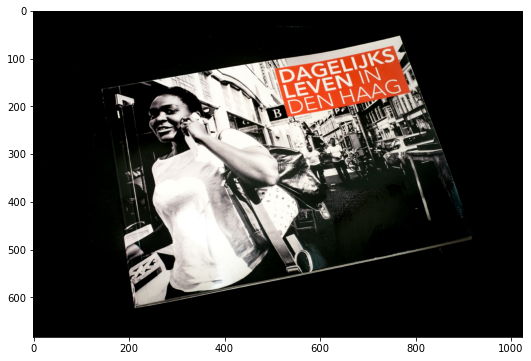

In [15]:
# 2値符号に変換する画像をndarrayで読み込む
img = Image.open(image_path)
img_array = np.array(img)
print('画像サイズ: ', img_array.shape)

fig = plt.figure(figsize=(9, 6))
plt.imshow(img);

In [20]:
bytesq_image = img_array[::step, ::step].reshape(-1)
if ebtb:
    bitsq_image = md.eightb_tenb(bytesq_image)
else:
    bitsq_image = md.image_to_binary(bytesq_image)

print('ビット列: ', bitsq_image[:128])
print('ビット長: ', bitsq_image.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21321/21321 [00:02<00:00, 9278.75it/s]

ビット列:  [0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0
 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0
 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0]
ビット長:  (213210,)


# 2. 2値符号を変調する

In [22]:
form = 'RZ16QAM'  # 変調方式(NRZQPSK or RZQPSK or NRZ16QAM or RZ16QAM)
n = 32  # 変調時の1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか

In [36]:
mdl = md.Modulate(form=form, n=n, equalize=equalize)
modsq = mdl.transform(bitsq_prbs) # 1.1. で作ったprbsを変調する

print('シンボル列: ', modsq)
print('シンボル長: ', modsq.shape)

rz16QAM modulation START
シンボル列:  [0.        +0.j         0.0438346 -0.0438346j  0.08724704-0.08724704j ...
 0.38945776+0.12981925j 0.26174113+0.08724704j 0.13150379+0.0438346j ]
シンボル長:  (65536,)


In [37]:
# 変調信号をサンプリングする
sampling = 2 # 1シンボルあたり何点でサンプリングするか[/symbol]
modsq_sampled = sampling_signal(modsq, n, sampling)

print('シンボル列: ', modsq_sampled)
print('シンボル長: ', modsq_sampled.shape)

シンボル列:  [0.        +0.j        0.4472136 -0.4472136j 0.        +0.j        ...
 1.34164079+0.4472136j 0.        +0.j        1.34164079+0.4472136j]
シンボル長:  (4096,)


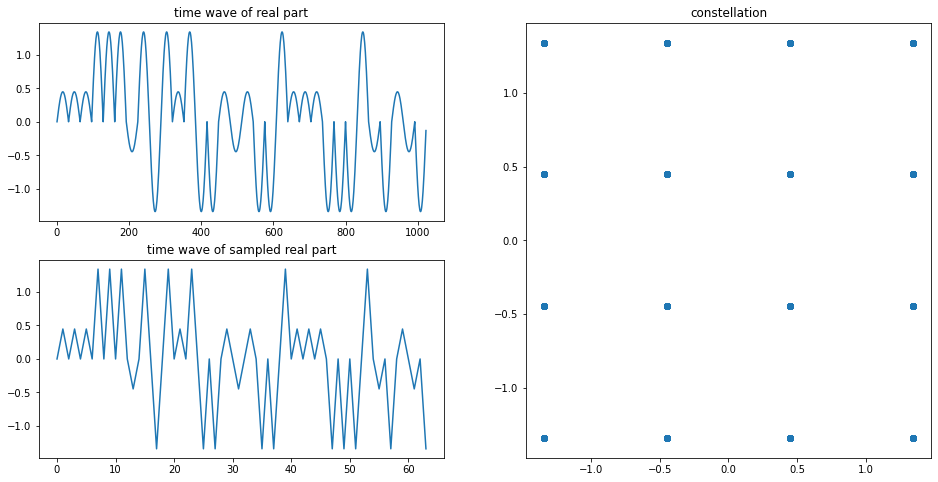

In [38]:
# グラフ化
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(1, 2, 2)

ax1.plot(modsq[:n * 32].real)
ax1.set_title('time wave of real part')

ax2.plot(modsq_sampled[:sampling * 32].real)
ax2.set_title('time wave of sampled real part')

ax3.plot(modsq[n//2:: n].real, modsq[n//2:: n].imag, 'o')
ax3.set_title('constellation');

# 3. 伝送シミュレーションする

In [28]:
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]

Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

In [39]:
# 伝送
sgnl = tr.Signal(seq=modsq,
                 form=form,
                 n=n,
                 baudrate=baudrate,
                 PdBm=PdBm,
                 Ledfa=Ledfa,
                 stepedfa=stepedfa,
                 gamma=gamma,
                 D=D,
                 Alpha=Alpha,
                 NF=NF)
sgnl.transmission(Lmax=Lmax, ase=ase)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]


In [40]:
# 信号品質の評価
signal_in = sgnl.signal['x_0'] # 伝送前
signal_in_peak = signal_in[n//2:: n] # 伝送前のピークのみ
signal = sgnl.signal['x_500'] # 500[km]伝送後
signal_peak = signal[n//2:: n] # 伝送後のピークのみ
signal_lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_500']) # 100%線形歪補償後
signal_lc_peak = signal_lc[n//2:: n] # 100%線形歪補償後のピークのみ

print('位相回転量(理論値): ', sgnl.phase_rotation_theo(Lmax))
print('位相回転量(シミュレーション値): ', sgnl.phase_rotation_simu(Lmax, signal_lc_peak)) # コードが不完全で、位相回転量大のときに誤る可能性あり
print('EVM(補償無し): ', sgnl.cal_evm(Lmax, signal_peak))
print('EVM(100%線形補償): ', sgnl.cal_evm(Lmax, signal_lc_peak))
print('EVM(100%線形補償+位相回転補償): ', sgnl.cal_evm_pr(Lmax, signal_lc_peak))
print('BER(100%線形補償): ', sgnl.cal_ber(Lmax, signal_lc_peak))
print('Q値(100%線形補償): ', sgnl.cal_qfac(Lmax, signal_lc_peak))

位相回転量(理論値):  13.360929357464112
位相回転量(シミュレーション値):  13.531144940089602
EVM(補償無し):  139.67113327916502
EVM(100%線形補償):  24.009208795915768
EVM(100%線形補償+位相回転補償):  4.814826206659174
BER(100%線形補償):  0.023440487558151646
Q値(100%線形補償):  5.965591744965265


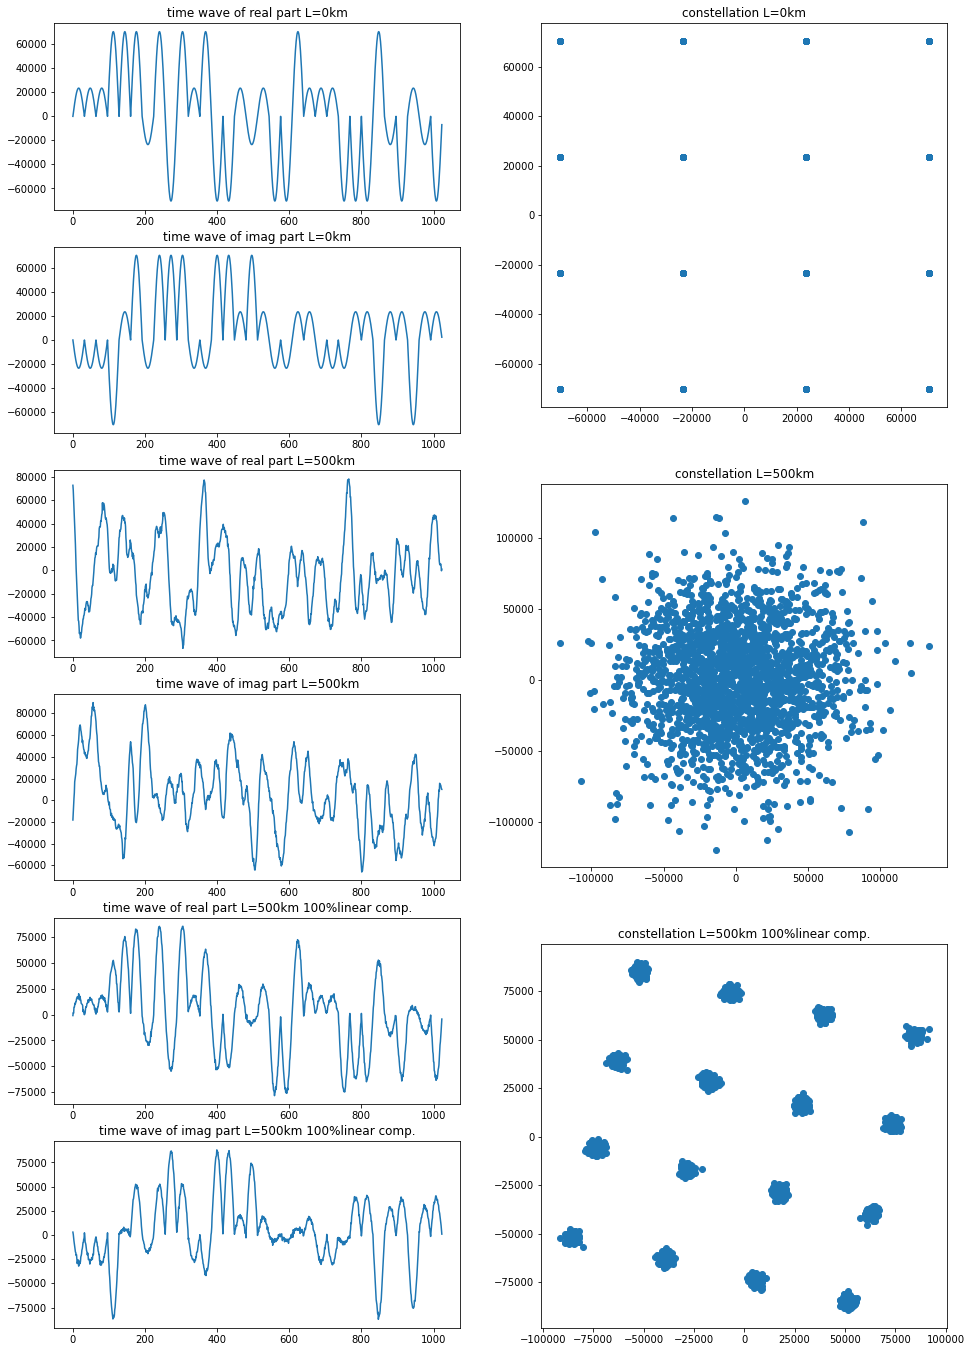

In [41]:
# グラフ化
fig = plt.figure(figsize=(16, 24))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 3)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(6, 2, 5)
ax5 = fig.add_subplot(6, 2, 7)
ax6 = fig.add_subplot(3, 2, 4)
ax7 = fig.add_subplot(6, 2, 9)
ax8 = fig.add_subplot(6, 2, 11)
ax9 = fig.add_subplot(3, 2, 6)

ax1.plot(signal_in[:32 * n].real)
ax1.set_title('time wave of real part L=0km')
ax2.plot(signal_in[:32 * n].imag)
ax2.set_title('time wave of imag part L=0km')
ax3.plot(signal_in_peak.real, signal_in_peak.imag, 'o')
ax3.set_title('constellation L=0km')

ax4.plot(signal[:32 * n].real)
ax4.set_title('time wave of real part L=500km')
ax5.plot(signal[:32 * n].imag)
ax5.set_title('time wave of imag part L=500km')
ax6.plot(signal_peak.real, signal_peak.imag, 'o')
ax6.set_title('constellation L=500km')

ax7.plot(signal_lc[:32 * n].real)
ax7.set_title('time wave of real part L=500km 100%linear comp.')
ax8.plot(signal_lc[:32 * n].imag)
ax8.set_title('time wave of imag part L=500km 100%linear comp.')
ax9.plot(signal_lc_peak.real, signal_lc_peak.imag, 'o')
ax9.set_title('constellation L=500km 100%linear comp.');